<a href="https://colab.research.google.com/github/ykt345/temp/blob/master/DALL_E_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# セットアップ

In [1]:
# GPUスペック確認
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-525c4529-3e1c-9089-02a1-675ee229402a)


In [2]:
# Pytorchバージョン変更
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html 

# Pytorch画像処理ライブラリー・インストール
! pip install kornia

# CLIP関連コードのコピー
! git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

# CLIPのモデル化
! pip install ftfy regex
import clip
model, preprocess = clip.load('ViT-B/32', jit=True)  
model = model.eval()  

# DALL-Eのモデル化
! pip install DALL-E
from dall_e import map_pixels, unmap_pixels, load_model
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')  


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.2 MB/s eta 0:04:22tcmalloc: large alloc 1147494400 bytes == 0x559d688c6000 @  0x7f2cbeed4615 0x559d2f7ac4cc 0x559d2f88c47a 0x559d2f7af2ed 0x559d2f8a0e1d 0x559d2f822e99 0x559d2f81d9ee 0x559d2f7b0bda 0x559d2f822d00 0x559d2f81d9ee 0x559d2f7b0bda 0x559d2f81f737 0x559d2f8a1c66 0x559d2f81edaf 0x559d2f8a1c66 0x559d2f81edaf 0x559d2f8a1c66 0x559d2f81edaf 0x559d2f7b1039 0x559d2f7f4409 0x559d2f7afc52 0x559d2f822c25 0x559d2f81d9ee 0x559d2f7b0bda 0x559d2f81f737 0x559d2f81d9ee 0x559d2f7b0bda 0x559d2f81e915 0x559d2f7b0afa 0x559d2f81ec0d 0x559d2f81d9ee
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:23tcmalloc: large alloc 1434370048 bytes == 0x559dacf1c000 @  0x7f2cbeed4615 0x559d2f7ac4cc 0x559d2f88c47a 0x559d2f7af2ed 0x559d2f8a0e1d 0x559d2f822e99 0x559d2f81d9ee 0x559d2f7b0bda 0x559d2f822d00 0x559d2f81d9ee 0x559d2f7b0bda 0x559d2f81f737 0x559d2f8a1c66 0x559d2f81ed

100%|███████████████████████████████████████| 338M/338M [01:28<00:00, 3.99MiB/s]


     |████████████████████████████████| 14.0 MB 31.0 MB/s 
     |████████████████████████████████| 65 kB 5.4 MB/s 
     |████████████████████████████████| 2.0 MB 66.5 MB/s 
     |████████████████████████████████| 138 kB 77.3 MB/s 
     |████████████████████████████████| 843 kB 74.3 MB/s 
     |████████████████████████████████| 127 kB 81.0 MB/s 
     |████████████████████████████████| 776.8 MB 17 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: torch
    Found existing installation: torch 1.10.1
    Uninstalling torch-1.10.1:
      Successfully uninstalled torch-1.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu1

# ライブラリー・インポート＆関数定義


In [3]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import kornia
import PIL
import os, io, sys
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from google.colab import output
import requests

# 初期設定
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape
target_image_size = sideX
tau_value = 2.

# 画像表示・保存
def displ(img):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  imageio.imwrite('output.png', np.array(img))
  return display.Image('output.png')

# 画像のランダム切り出し
def augment(out, cutn=16):
  p_s = []
  for ch in range(cutn):
    sizey = int(torch.zeros(1,).uniform_(.5, .99)*sideY)
    sizex = int(torch.zeros(1,).uniform_(.5, .99)*sideX)
    offsetx = torch.randint(0, sideX - sizex, ())
    offsety = torch.randint(0, sideY - sizey, ())
    apper = out[:, :, offsetx:offsetx + sizex, offsety:offsety + sizey]
    apper = apper + .1*torch.rand(1,1,1,1).cuda()*torch.randn_like(apper, requires_grad=True)
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = augs(torch.cat(p_s, 0))
  return into

# 正規化と回転設定
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
augs = kornia.augmentation.RandomRotation(30).cuda()

# パラメータの設定
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        hots = torch.nn.functional.one_hot((torch.arange(0, 8192).to(torch.int64)), num_classes=8192)
        rng = torch.zeros(1, 64*64, 8192).uniform_()
        for i in range(64*64):
            rng[0,i] = hots[[np.random.randint(8191)]]
        rng = rng.permute(0, 2, 1)
        self.normu = torch.nn.Parameter(rng.cuda().view(1, 8192, 64*64))
        
    def forward(self):      
      normu = torch.nn.functional.gumbel_softmax(self.normu.reshape(1,64*64,8192), dim=1, tau=tau_value).view(1, 8192, 64, 64)
      return normu 


# テキストから画像の生成

**テキストから特徴ベクトルを抽出**

In [8]:
# テキスト入力
text_input = 'blackpink drinking a chocolate-orange latte'

# テキストを特徴ベクトルに変換
token = clip.tokenize(text_input)  
text_v = model.encode_text(token.cuda()).detach().clone() 

**学習**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


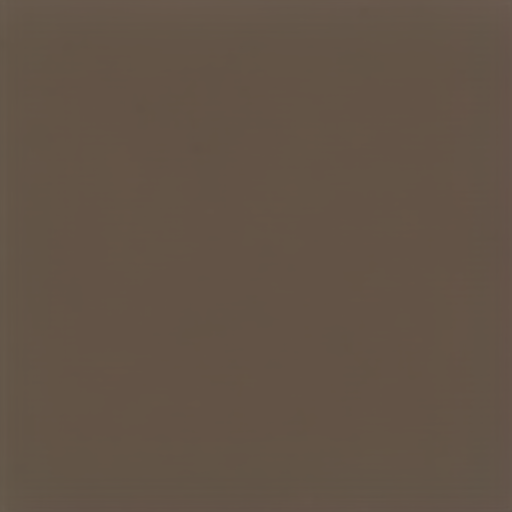

'./images/000000.png'

iter =  0
lr =  0.01005
tau_value =  2.0
loss =  -0.200927734375




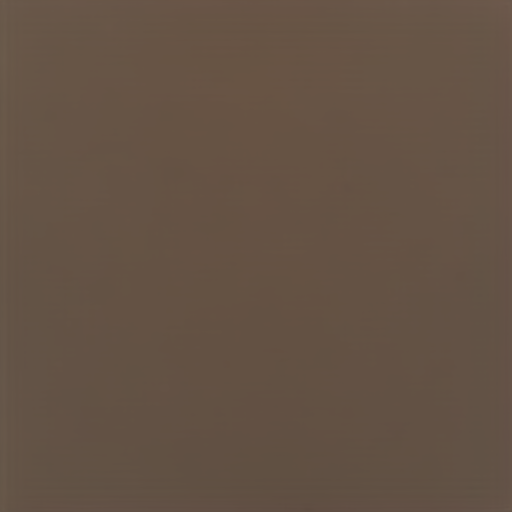

'./images/000001.png'

iter =  50
lr =  0.0128964194401004
tau_value =  2.0
loss =  -0.200439453125




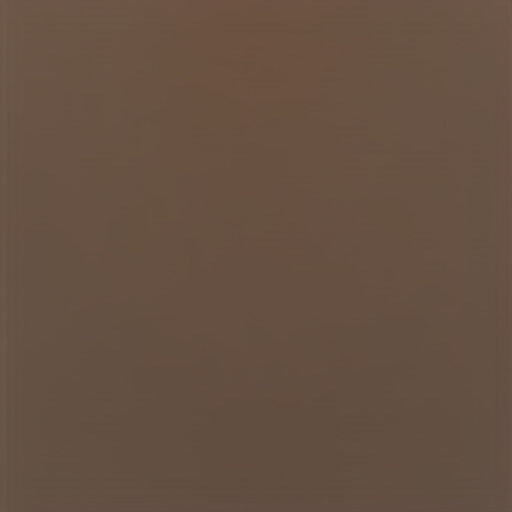

'./images/000002.png'

iter =  100
lr =  0.0165490183457711
tau_value =  2.0
loss =  -0.1942138671875




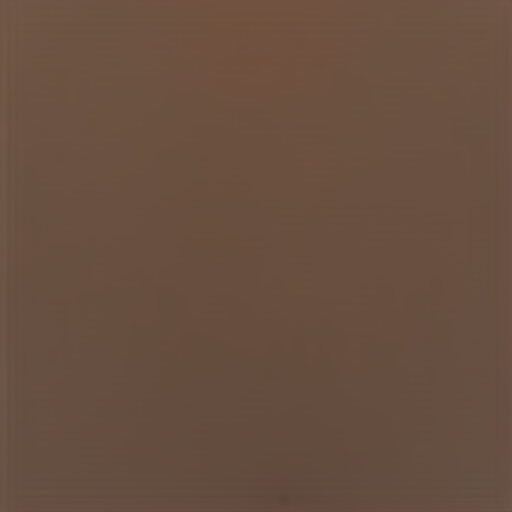

'./images/000003.png'

iter =  150
lr =  0.0212361275531324
tau_value =  2.0
loss =  -0.208984375




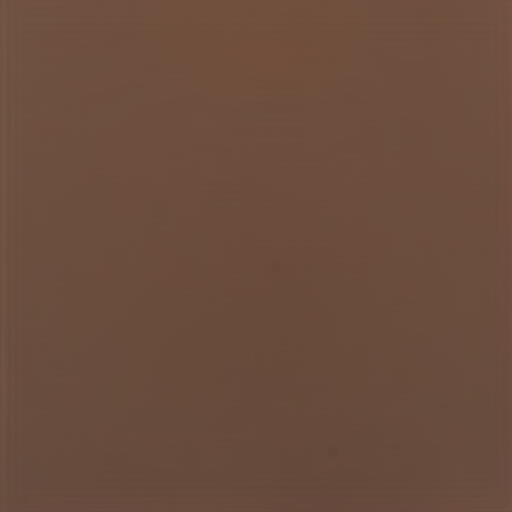

'./images/000004.png'

iter =  200
lr =  0.027250747085439654
tau_value =  2.0
loss =  -0.2071533203125




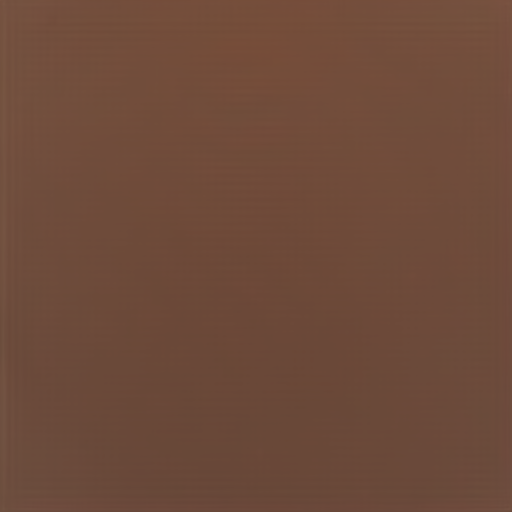

'./images/000005.png'

iter =  250
lr =  0.03496886213631078
tau_value =  2.0
loss =  -0.211669921875




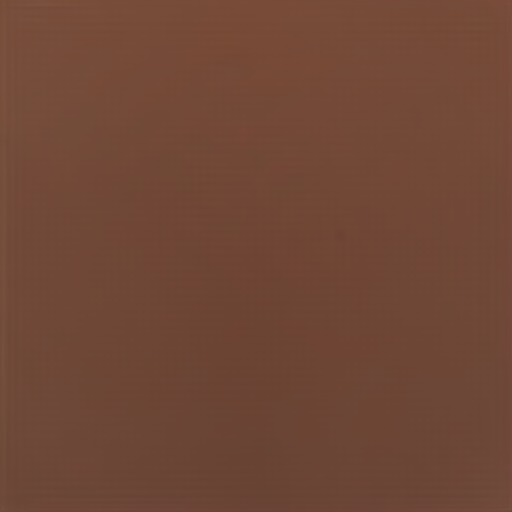

'./images/000006.png'

iter =  300
lr =  0.0448729466122298
tau_value =  2.0
loss =  -0.2115478515625




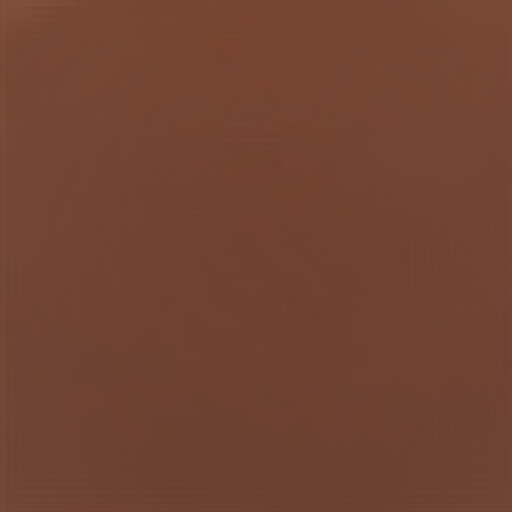

'./images/000007.png'

iter =  350
lr =  0.05758212348502963
tau_value =  2.0
loss =  -0.225341796875




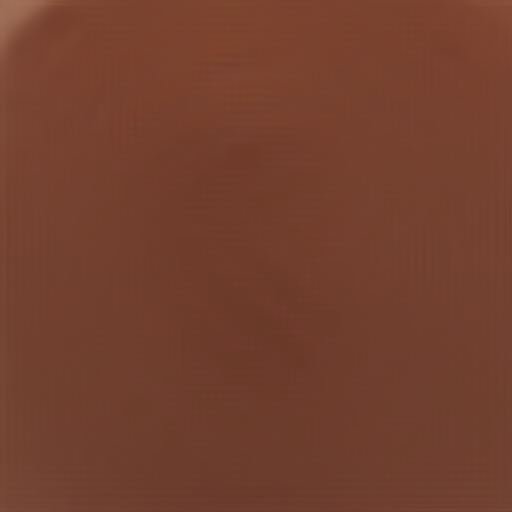

'./images/000008.png'

iter =  400
lr =  0.07389086733478589
tau_value =  2.0
loss =  -0.219482421875




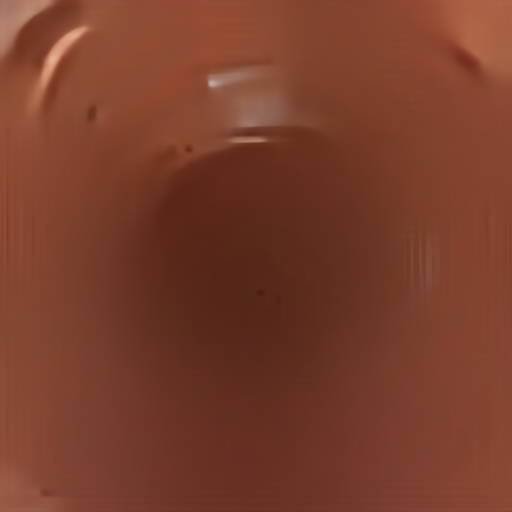

'./images/000009.png'

iter =  450
lr =  0.09481866845196141
tau_value =  2.0
loss =  -0.2489013671875




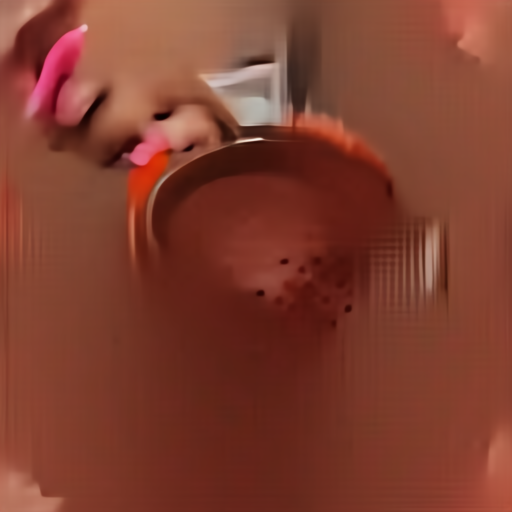

'./images/000010.png'

iter =  500
lr =  0.12
tau_value =  2.0
loss =  -0.335205078125




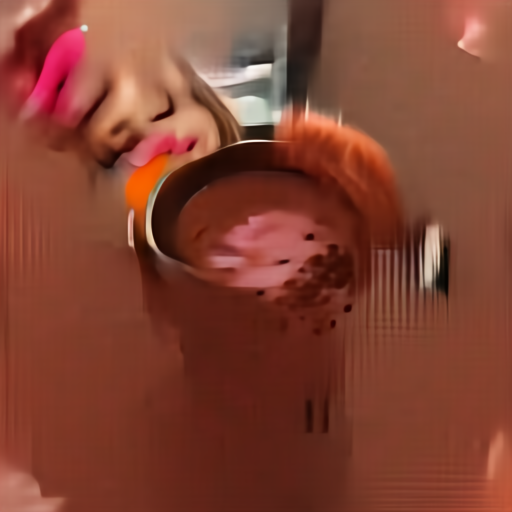

'./images/000011.png'

iter =  550
lr =  0.12
tau_value =  2.0
loss =  -0.406982421875




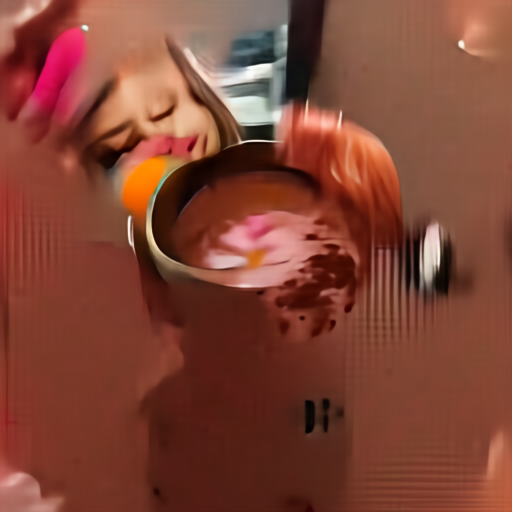

'./images/000012.png'

iter =  600
lr =  0.12
tau_value =  2.0
loss =  -0.411865234375




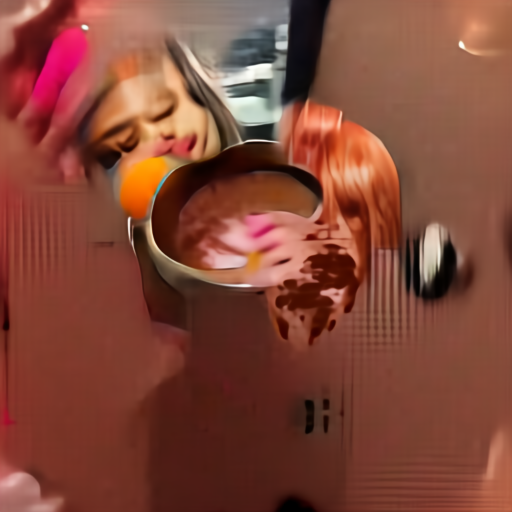

'./images/000013.png'

iter =  650
lr =  0.12
tau_value =  2.0
loss =  -0.447021484375




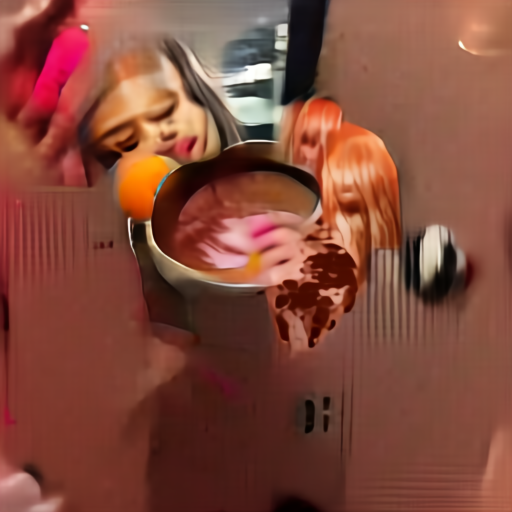

'./images/000014.png'

iter =  700
lr =  0.12
tau_value =  2.0
loss =  -0.471923828125




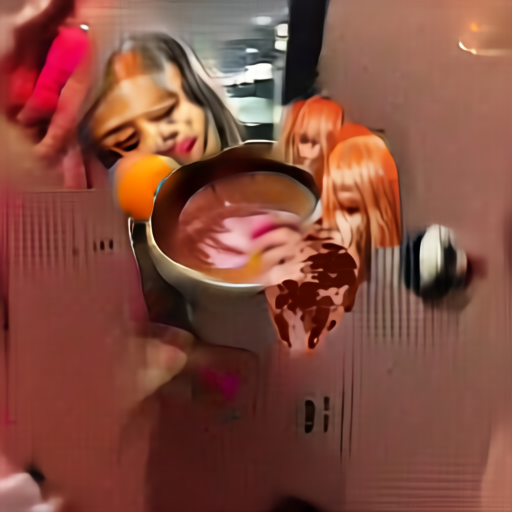

'./images/000015.png'

iter =  750
lr =  0.12
tau_value =  2.0
loss =  -0.477783203125




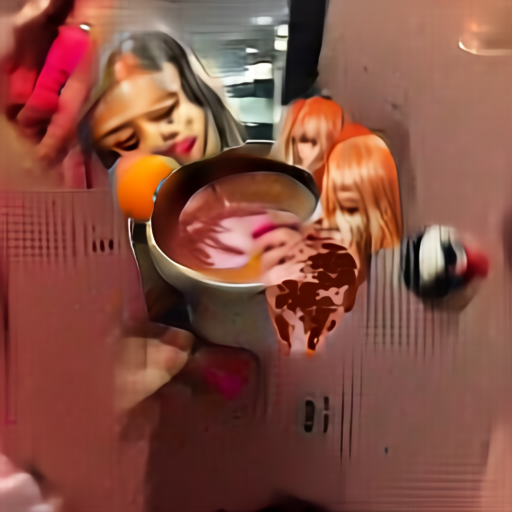

'./images/000016.png'

iter =  800
lr =  0.12
tau_value =  2.0
loss =  -0.491943359375




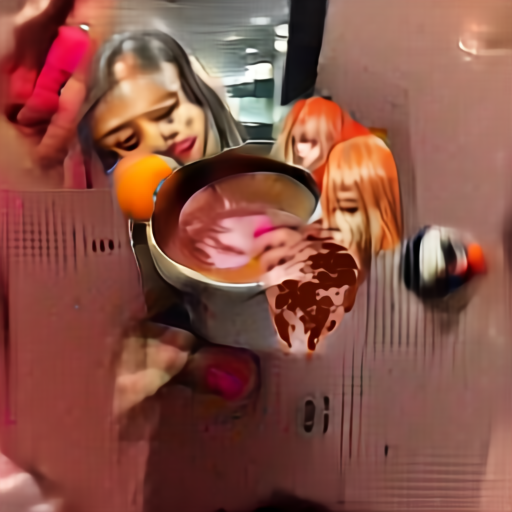

'./images/000017.png'

iter =  850
lr =  0.12
tau_value =  2.0
loss =  -0.4921875




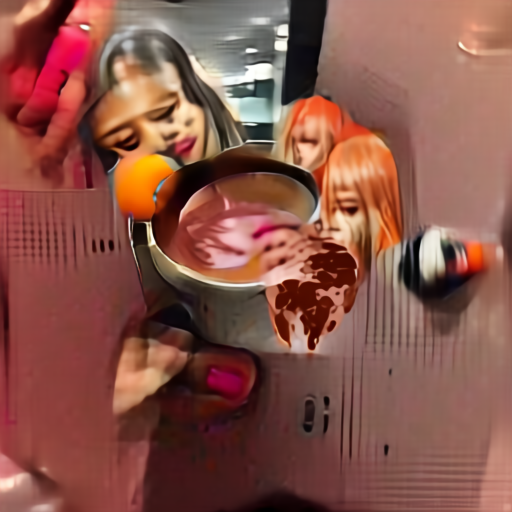

'./images/000018.png'

iter =  900
lr =  0.12
tau_value =  2.0
loss =  -0.48291015625




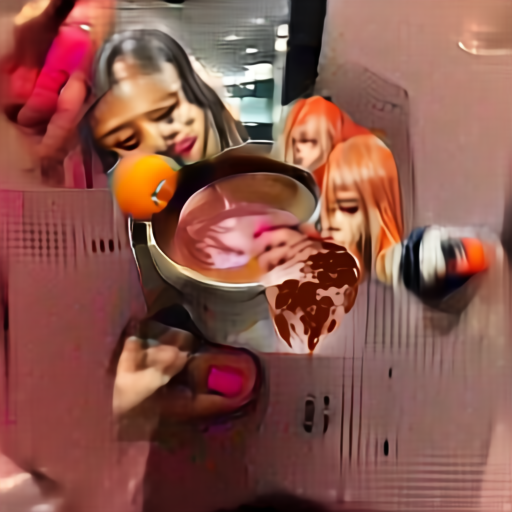

'./images/000019.png'

iter =  950
lr =  0.12
tau_value =  2.0
loss =  -0.4921875




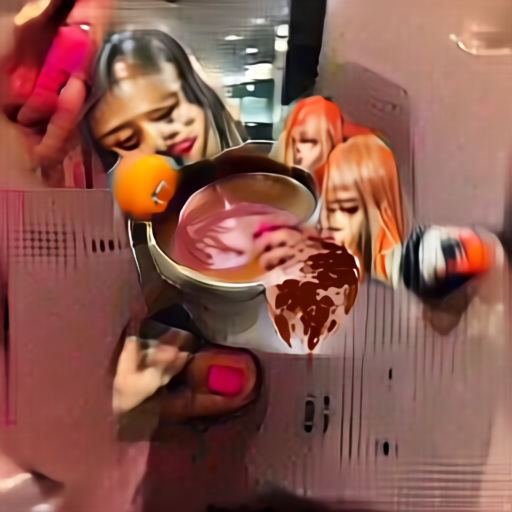

'./images/000020.png'

iter =  1000
lr =  0.12
tau_value =  2.0
loss =  -0.48583984375




In [9]:
# パラメータリセット
latent = Pars().cuda()  
param = [latent.normu]  
optimizer = torch.optim.Adam([{'params': param, 'lr': .01}]) 

# images フォルダーリセット
import os
import shutil
if os.path.isdir('images'):
   shutil.rmtree('images')
os.makedirs('images', exist_ok=True)

# 学習ループ
for iteration in range(1001):

  # --- 順伝播 ---
  # パラメータから画像を生成
  out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3].float()))
  # 画像をランダム切り出し・回転  
  into = augment(out)
  # 画像を正規化
  into = nom((into))
  # 画像から特徴ベクトルを取得
  image_v = model.encode_image(into)
  # テキストと画像の特徴ベクトルのCOS類似度を計算 
  loss = -torch.cosine_similarity(text_v, image_v).mean()  

  # 逆伝播
  optimizer.zero_grad()
  loss.backward()
  optimizer.step() 

  # 学習率の調整
  for g in optimizer.param_groups:
    g['lr'] = g['lr']*1.005
    g['lr'] = min(g['lr'], .12)

  # ログ表示      
  if iteration % 50 == 0:
    with torch.no_grad():

      # 生成画像の表示・保存
      out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3]).float())  
      displ(out.cpu()[0])  
      shutil.copy('output.png', './images/%s.png'%str(int(iteration/50)).zfill(6))

      # データ表示
      print('iter = ',iteration)
      for g in optimizer.param_groups:
        print('lr = ', g['lr'])
      print('tau_value = ', tau_value)
      print('loss = ',loss.item())
      print('\n')


# 学習過程の動画作成

**mp4動画の作成**

In [10]:
# images フォルダーの最後の画像を5枚コピー
import shutil
for i in range(21,26,1):
    shutil.copy('output.png', './images/%s.png'%str(int(i)).zfill(6))

# ouput.mp4を一旦削除
import os 
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# images フォルダーの画像から動画を生成
! ffmpeg -r 5 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p output.mp4

'./images/000021.png'

'./images/000022.png'

'./images/000023.png'

'./images/000024.png'

'./images/000025.png'

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

**mp4動画の再生**

In [11]:
from IPython.display import HTML
from base64 import b64encode
 
mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="50%" height="50%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")